#**Neural Networks**

In [ ]:
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp

In [ ]:
# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

In [ ]:
# Test Backprop on Seeds dataset
seed(1)
#load and prepare data
filename = '/content/drive/MyDrive/dmkd project/apis.csv'
dataset = load_csv(filename)

In [ ]:
dataset[:4]

[['',
  'inter_api_access_duration(sec)',
  'api_access_uniqueness',
  'sequence_length(count)',
  'vsession_duration(min)',
  'ip_type',
  'behavior',
  'behavior_type',
  'num_sessions',
  'num_users',
  'num_unique_apis',
  'source'],
 ['0',
  '7.010387096774193',
  '0.41935483870967744',
  '31.0',
  '13040',
  'default',
  'outlier',
  'outlier',
  '1.0',
  '1.0',
  '13.0',
  'E'],
 ['1',
  '51.419392523364486',
  '0.2523364485981308',
  '107.0',
  '330113',
  'default',
  'outlier',
  'outlier',
  '1.0',
  '1.0',
  '27.0',
  'E'],
 ['2',
  '25.860775',
  '0.275',
  '40.0',
  '62066',
  'default',
  'outlier',
  'outlier',
  '1.0',
  '1.0',
  '11.0',
  'E']]

In [ ]:
# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	print(unique)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup


In [ ]:
for i in range(len(dataset[0])-1):
	str_column_to_int(dataset, i)
 
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)

{'', '18613', '28482', '3134', '8036', '3107', '10657', '15343', '2620', '6946', '26723', '7115', '19288', '1630', '14664', '22858', '2521', '15385', '0', '17307', '24095', '25119', '33826', '12146', '19322', '45', '23673', '18022', '8766', '17931', '3934', '7979', '33467', '27596', '32852', '11289', '10889', '20675', '18726', '19039', '32335', '22130', '14468', '22558', '4624', '3041', '5758', '30697', '2858', '1864', '1897', '34067', '185', '4993', '18389', '25878', '13719', '1106', '5017', '22511', '24986', '12463', '19544', '22991', '28926', '31244', '20554', '10340', '20196', '27253', '31089', '20302', '2892', '5778', '16451', '29807', '12289', '5368', '13470', '34151', '6004', '9483', '6687', '12018', '32114', '22999', '34120', '8660', '33303', '17734', '9413', '27532', '10163', '14234', '33710', '2894', '3259', '402', '21169', '12758', '24995', '30061', '31581', '29490', '1815', '2854', '30838', '10094', '31050', '14228', '11833', '19568', '12328', '6337', '15021', '14607', '831

{'E': 0, 'F': 1, 'source': 2}

In [ ]:
# Find the min and max values for each column
def dataset_minmax(dataset):
	minmax = list()
	stats = [[min(column), max(column)] for column in zip(*dataset)]
	return stats

# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
	for row in dataset:
		for i in range(len(row)-1):
			row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

In [ ]:
# normalize input variables
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)

In [ ]:
dataset[:3]

[[0.0,
  0.8344123505976095,
  0.6449713311637998,
  0.033177954483136825,
  0.5764230589941473,
  1.0,
  0.5866666666666667,
  1.0,
  0.036211699164345405,
  0.3829787234042553,
  0.336,
  2],
 [0.0005208031942595915,
  0.34057519920318724,
  0.43700604370060436,
  0.0743076501233891,
  0.1055575697933392,
  0.25,
  0.41333333333333333,
  0.5,
  0.22284122562674094,
  0.8936170212765957,
  0.504,
  0],
 [0.5138012846478792,
  0.9924365039840638,
  0.8688981868898187,
  0.6142034548944337,
  0.2022064536178588,
  0.25,
  0.41333333333333333,
  0.5,
  0.22284122562674094,
  0.8936170212765957,
  0.008,
  0]]

# **Neural Network**

In [ ]:
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()
	hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	network.append(hidden_layer)
	output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network

In [ ]:
# Update network weights with error
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] -= l_rate * neuron['delta'] * inputs[j]
			neuron['weights'][-1] -= l_rate * neuron['delta']

## **Sigmoid Activation Function**

In [ ]:
# Calculate neuron activation for an input
def activate(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation

# Transfer neuron activation
def transfer(activation):
	return 1.0 / (1.0 + exp(-activation))

# **Back propagation**

In [ ]:
# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
    for epoch in range(n_epoch):
        sum_error = 0
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1
            sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
            backward_propagate_error(network, expected)
            update_weights(network, row, l_rate)
        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))

# **Gradient Descent Method**

In [ ]:
# Forward propagate input to a network output
def forward_propagate(network, row):
	inputs = row
	for layer in network:
		new_inputs = []
		for neuron in layer:
			activation = activate(neuron['weights'], inputs)
			neuron['output'] = transfer(activation)
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs

In [ ]:
# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
    for epoch in range(n_epoch):
        sum_error = 0
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1
            sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
            backward_propagate_error(network, expected)
            update_weights(network, row, l_rate)
        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))

**Back Propagation Rules**

In [ ]:
# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(neuron['output'] - expected[j])
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])


In [ ]:
# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
	n_inputs = len(train[0]) - 1
	n_outputs = len(set([row[-1] for row in train]))
	network = initialize_network(n_inputs, n_hidden, n_outputs)
	train_network(network, train, l_rate, n_epoch, n_outputs)
	predictions = list()
	for row in test:
		prediction = predict(network, row)
		predictions.append(prediction)
	return(predictions)

**Termination Criteria**

In [ ]:
# Calculate the derivative of an neuron output
def transfer_derivative(output):
	return output * (1.0 - output)

In [ ]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

In [ ]:
# Make a prediction with a network
def predict(network, row):
	outputs = forward_propagate(network, row)
	return outputs.index(max(outputs))

**Learning Rate**

In [ ]:
len(dataset)

34563

In [ ]:
n_folds = 5
l_rate = 0.1
n_epoch = 1500
n_hidden = 8
scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

>epoch=0, lrate=0.100, error=9736.934
>epoch=1, lrate=0.100, error=8694.737
>epoch=2, lrate=0.100, error=8636.315
>epoch=3, lrate=0.100, error=8590.213
>epoch=4, lrate=0.100, error=8555.437
>epoch=5, lrate=0.100, error=8527.989
>epoch=6, lrate=0.100, error=8506.337
>epoch=7, lrate=0.100, error=8488.485
>epoch=8, lrate=0.100, error=8472.066
>epoch=9, lrate=0.100, error=8455.723
>epoch=10, lrate=0.100, error=8438.828
>epoch=11, lrate=0.100, error=8421.213
>epoch=12, lrate=0.100, error=8403.117
>epoch=13, lrate=0.100, error=8385.166
>epoch=14, lrate=0.100, error=8368.170
>epoch=15, lrate=0.100, error=8352.738
>epoch=16, lrate=0.100, error=8339.060
>epoch=17, lrate=0.100, error=8327.003
>epoch=18, lrate=0.100, error=8316.310
>epoch=19, lrate=0.100, error=8306.730
>epoch=20, lrate=0.100, error=8298.058
>epoch=21, lrate=0.100, error=8290.132
>epoch=22, lrate=0.100, error=8282.823
>epoch=23, lrate=0.100, error=8276.026
>epoch=24, lrate=0.100, error=8269.661
>epoch=25, lrate=0.100, error=8263.

KeyboardInterrupt: ignored

# **Clustering**

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
X = df.iloc[:, [1, 2]].values

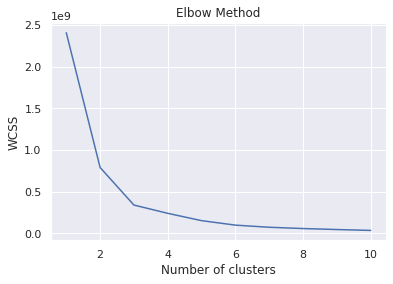

In [ ]:
from sklearn.cluster import KMeans
# (Within-Cluster Sum of Square)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
df.head(2)

,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,behavior,behavior_type,num_sessions,num_users,num_unique_apis,source
0,-1.0,25.0,386.0,70.0,1.0,9.0,1,1.0,1.0,20.0,0
1,-1.0,-1.0,10.0,36.0,1.0,9.0,1,1.0,1.0,7.0,0


# **Hierarchical Clustering**

In [ ]:
import scipy.cluster.hierarchy as sch
import sys
#sys.setrecursionlimit(1000000)
plt.figure(figsize=(15,17))
dendrogram = sch.dendrogram(sch.linkage(X, method = 'complete'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

RecursionError: ignored

<Figure size 1080x1224 with 0 Axes>

# **Aggolomerative Clustering**
## **Single linkage**

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'single')
y_hc = hc.fit_predict(X)

In [ ]:
# Visualising the clusters

plt.figure(figsize=(8,8))
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = 'Careful Customers')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'blue', label = 'Standard Customers')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'green', label = 'Luxury Customers')
plt.scatter(X[y_hc == 3, 0], X[y_hc == 3, 1], s = 100, c = 'cyan', label = 'Careless Customers')
plt.scatter(X[y_hc == 4, 0], X[y_hc == 4, 1], s = 100, c = 'magenta', label = 'Sensible Customers')
plt.title('Clusters of customers using Hierarchical Clustering')
plt.xlabel('Annual Income (K$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

TypeError: ignored

<Figure size 576x576 with 0 Axes>

# **Model Evaluation**

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/dmkd project/apis.csv')

#Check number of rows and columns in the dataset
print("The dataset has %d rows and %d columns." % df.shape)

The dataset has 34562 rows and 12 columns.


In [ ]:
df[pd.isnull(df).any(axis=1)]

,Unnamed: 0,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,behavior,behavior_type,num_sessions,num_users,num_unique_apis,source
1117,1117,NaN,NaN,0.0,3,aws_datacenter,outlier,outlier,4.0,1.0,0.0,E
1360,1360,NaN,NaN,0.0,3,aws_datacenter,outlier,outlier,2.0,1.0,0.0,E
1776,1776,NaN,NaN,0.0,3,aws_datacenter,outlier,outlier,4.0,1.0,0.0,E
10718,10718,NaN,NaN,0.0,3,default,outlier,outlier,2.0,1.0,0.0,E
12348,12348,NaN,NaN,0.0,3,aws_datacenter,outlier,outlier,2.0,1.0,0.0,E


In [ ]:
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
df.drop([1117,1360,1776,10718,12348],axis=0,inplace=True)

We need to transform all categorical data to numerical ones. That's why we are applying some Lambda functions to our dataset columns.

In [ ]:
df["source"] = df["source"].apply(lambda x: 0 if x=="E" else 1)

In [ ]:
# 0 = private_ip, 1 = default and 2 = aws_datacenter
df["ip_type"] = df["ip_type"].apply(lambda x: 0 if x=="private_ip" else (1 if x=="default" else 0))

In [ ]:
# 0 = bot, 1 = outlier
df["behavior_type"] = df["behavior_type"].apply(lambda x: 0 if x=="o" else 1)

In [ ]:
# 0 = outlier, 1 = Normal, 2 = BingPreview/1.0b;bingbot/2.0, 3 = bingbot/2.0, 4 = AdsBot-Google, 5 = Python-requests, 6 = YandexBot/3.0, 7 = FacebookExternalHit/1.1;unknown, 8 = Remote Code Execution
df["behavior"] = df["behavior"].apply(lambda x: 0 if x=="outlier" else (1 if x=="Normal" else (2 if x=="BingPreview/1.0b;bingbot/2.0" else (3 if x=="bingbot/2.0" else (4 if x=="AdsBot-Google" else (5 if x=="Python-requests" else (6 if x=="YandexBot/3.0" else (7 if x=="FacebookExternalHit/1.1;unknown" else (8 if x=="Remote Code Execution" else 9 )))))))))

In [ ]:
df[pd.isnull(df).any(axis=1)]

,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,behavior,behavior_type,num_sessions,num_users,num_unique_apis,source


In [ ]:
df.head(3)

,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,behavior,behavior_type,num_sessions,num_users,num_unique_apis,source
0,7.010387,0.419355,31.0,13040,1,0,1,1.0,1.0,13.0,0
1,51.419393,0.252336,107.0,330113,1,0,1,1.0,1.0,27.0,0
2,25.860775,0.275000,40.0,62066,1,0,1,1.0,1.0,11.0,0


In [ ]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import os

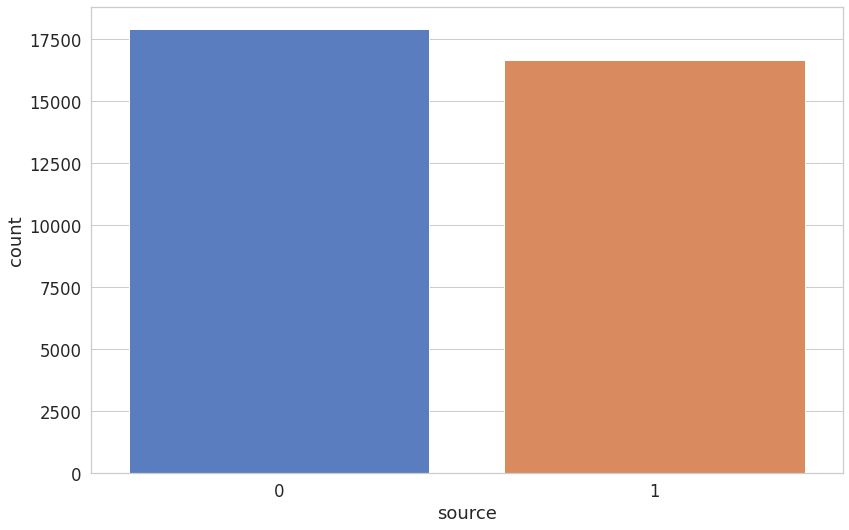

In [ ]:
sns.countplot(x='source',data=df)
plt.show()

In [ ]:
grouped = df.groupby('source').agg({'inter_api_access_duration(sec)':['mean', 'std', min, max],
                                       'api_access_uniqueness':['mean', 'std', min, max],
                                       'sequence_length(count)':['mean', 'std', min, max],
                                       'vsession_duration(min)':['mean', 'std', min, max],
                                       'ip_type':['mean', 'std', min, max],
                                       'behavior':['mean', 'std', min, max],
                                       'behavior_type':['mean', 'std', min, max],
                                       'num_sessions':['mean', 'std', min, max],
                                       'num_users':['mean', 'std', min, max],
                                       'num_unique_apis':['mean', 'std', min, max]
                                      })
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
grouped # or grouped.T

,inter_api_access_duration(sec)_mean,inter_api_access_duration(sec)_std,inter_api_access_duration(sec)_min,inter_api_access_duration(sec)_max,api_access_uniqueness_mean,api_access_uniqueness_std,api_access_uniqueness_min,api_access_uniqueness_max,sequence_length(count)_mean,sequence_length(count)_std,sequence_length(count)_min,sequence_length(count)_max,vsession_duration(min)_mean,vsession_duration(min)_std,vsession_duration(min)_min,vsession_duration(min)_max,ip_type_mean,ip_type_std,ip_type_min,ip_type_max,behavior_mean,behavior_std,behavior_min,behavior_max,behavior_type_mean,behavior_type_std,behavior_type_min,behavior_type_max,num_sessions_mean,num_sessions_std,num_sessions_min,num_sessions_max,num_users_mean,num_users_std,num_users_min,num_users_max,num_unique_apis_mean,num_unique_apis_std,num_unique_apis_min,num_unique_apis_max
source,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,13.742644,56.662352,0.00001,2333.627333,0.477938,0.294700,0.000714,1.0,95.504177,191.921124,1.0,2800.0,28824.142131,63386.634165,1,1266522,0.921844,0.268424,0,1,0.489589,1.940902,0,9,1.0,0.0,1,1,12.126500,88.948401,1.0,1462.0,1.865238,9.160005,1.0,219.0,18.964383,17.971979,1.0,178.0
1,27.779306,94.983100,0.00000,1527.227000,0.408034,0.306003,0.000714,1.0,32.774527,79.443045,1.0,2483.0,30233.245794,94216.865723,0,2787530,0.993992,0.077282,0,1,0.604843,0.860310,0,9,1.0,0.0,1,1,7.453317,15.175472,1.0,300.0,5.478010,11.485639,1.0,99.0,11.729512,10.728324,1.0,95.0


In [ ]:
df.columns

Index(['inter_api_access_duration(sec)', 'api_access_uniqueness',
       'sequence_length(count)', 'vsession_duration(min)', 'ip_type',
       'behavior', 'behavior_type', 'num_sessions', 'num_users',
       'num_unique_apis', 'source'],
      dtype='object')

<Figure size 864x576 with 0 Axes>

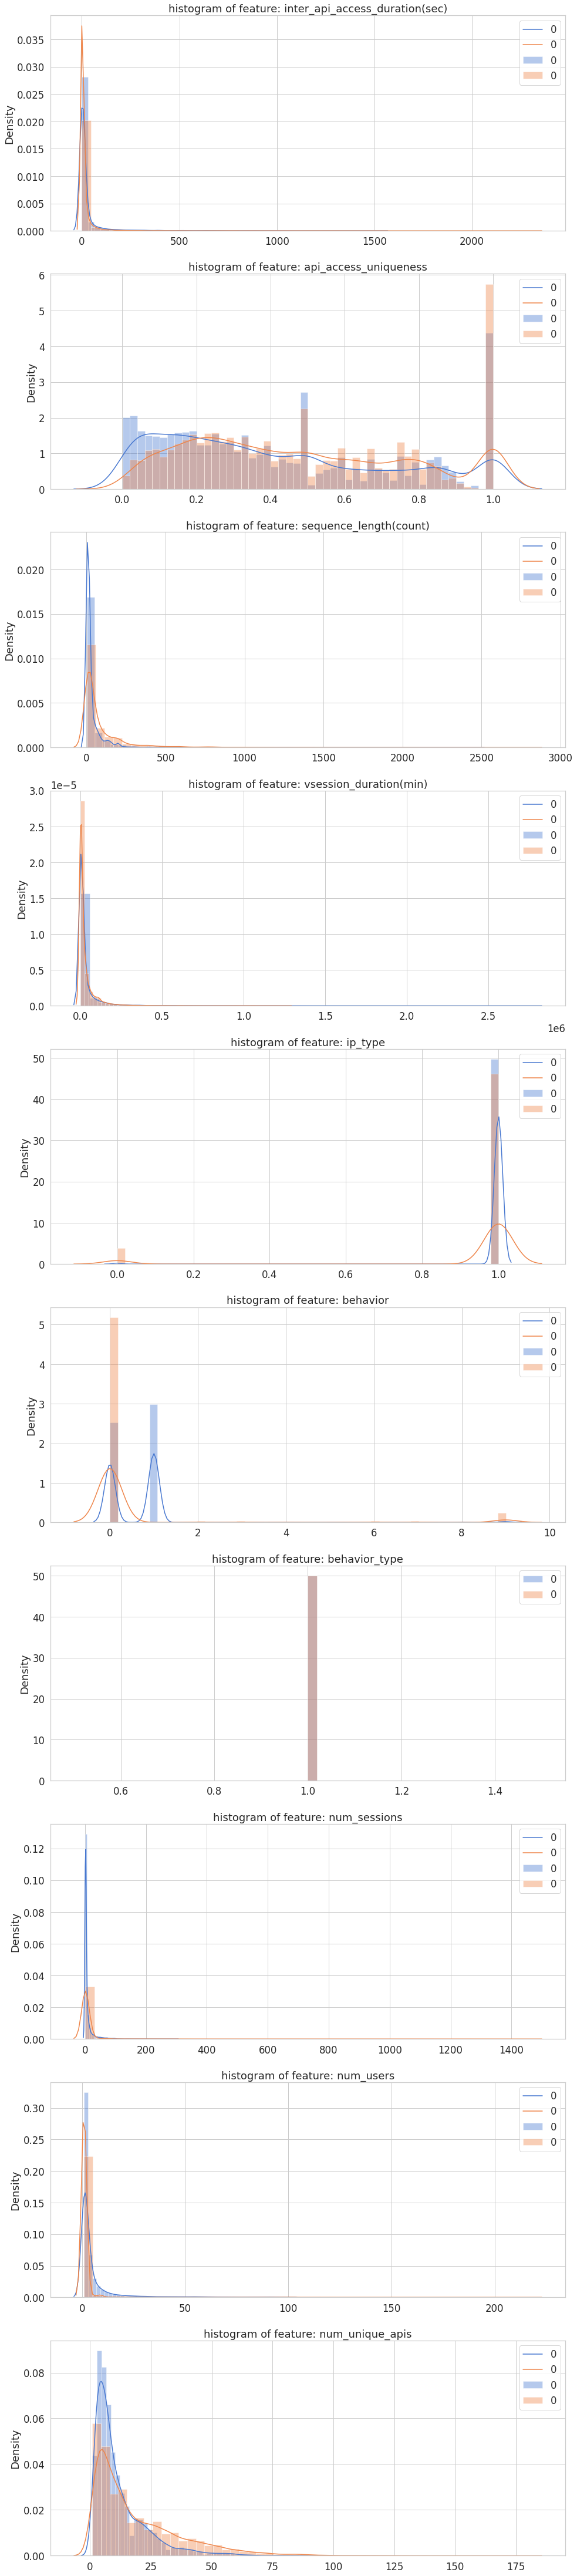

In [ ]:
plt.subplots_adjust(top=5)
columns=df.columns[:10]
plt.figure(figsize=(14,30*7))
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(df[columns]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.source == 1], bins=50)
    sns.distplot(df[cn][df.source == 0], bins=50)
    ax.set_xlabel('')
    plt.legend(df["source"])
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

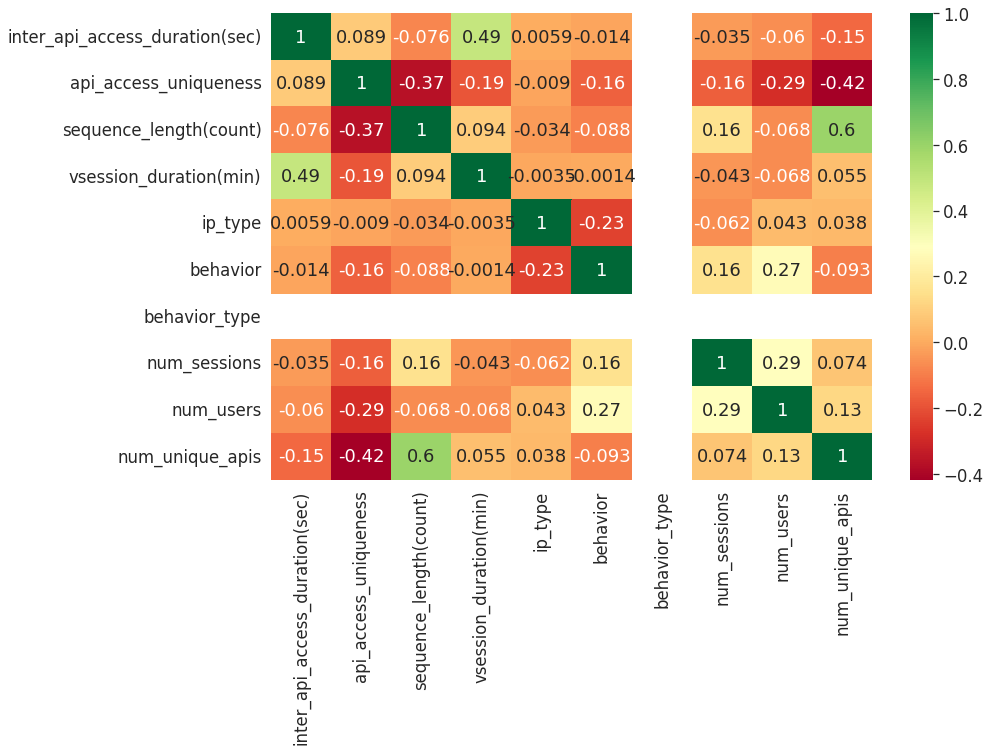

In [ ]:

sns.heatmap(df[df.columns[:10]].corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
plt.show()

Reset Dataset Again

# **Model Building**

In [ ]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install squarify

## **Holdout Method**

In [ ]:
outcome=df['source']
data=df[df.columns[:6]]

train,test = train_test_split(df,test_size=0.25,random_state=0,stratify=df['source'])# stratify the outcome

train_X=train[train.columns[:6]]
test_X=test[test.columns[:6]]
train_Y=train['source']
test_Y=test['source']

In [ ]:
print(train_X.shape)
print(test_X.shape)

(25917, 6)
(8640, 6)


### **Feature Centering and Scaling**

In [ ]:
features = train_X.columns.values

for feature in features:
    mean, std = df[feature].mean(), df[feature].std()
    train_X.loc[:, feature] = (train_X[feature] - mean) / std
    test_X.loc[:, feature] = (test_X[feature] - mean) / std

# **Compare model accuracies**

In [ ]:
accuracy_scores=[]

classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree', 'Random forest', 'Naive Bayes']

models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),
        KNeighborsClassifier(n_neighbors=3),DecisionTreeClassifier(), 
        RandomForestClassifier(n_estimators=100,random_state=0), GaussianNB()]
        
for i in models:
    model = i
    model.fit(train_X, train_Y)
    prediction=model.predict(test_X)
    accuracy_scores.append(metrics.accuracy_score(prediction,test_Y))
    
models_dataframe=pd.DataFrame(accuracy_scores,index=classifiers)   
models_dataframe.columns=['Accuracy']
models_dataframe.sort_values(['Accuracy'], ascending=False)

,Accuracy
Random forest,0.823380
KNN,0.815046
Radial Svm,0.802778
Decision Tree,0.796296
Linear Svm,0.697569
Logistic Regression,0.693056
Naive Bayes,0.592593


In [ ]:
modelRF= RandomForestClassifier(n_estimators=100,random_state=0)
modelRF.fit(train_X,train_Y)
predictionRF=modelRF.predict(test_X)
pd.Series(modelRF.feature_importances_,index=train_X.columns).sort_values(ascending=False)

behavior                          0.282085
inter_api_access_duration(sec)    0.204255
vsession_duration(min)            0.203388
sequence_length(count)            0.151883
api_access_uniqueness             0.140888
ip_type                           0.017501
dtype: float64

## **k-fold Cross validation**

In [ ]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.preprocessing import StandardScaler #Standardisation

In [ ]:
kfold = KFold(n_splits=6, random_state=0, shuffle=True)

In [ ]:
# Starting with the original dataset and then doing centering and scaling
features=df[df.columns[:10]]
features_standard=StandardScaler().fit_transform(features)# Gaussian Standardisation
X=pd.DataFrame(features_standard,columns=['inter_api_access_duration(sec)', 'api_access_uniqueness','sequence_length(count)', 'vsession_duration(min)', 'num_sessions', 'num_users','num_unique_apis','ip_type', 'behavior','behavior_type'])
X['source']=df['source']

In [ ]:
xyz=[]
accuracy=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree', 'Random forest', 'Naive Bayes']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),
        KNeighborsClassifier(n_neighbors=3),DecisionTreeClassifier(), 
        RandomForestClassifier(n_estimators=100,random_state=0), GaussianNB()]

for i in models:
    model = i
    cv_result = cross_val_score(model,X[X.columns[:9]], X['source'], cv = kfold, scoring = "accuracy")
    xyz.append(cv_result.mean())
    accuracy.append(cv_result)

cv_models_dataframe=pd.DataFrame(xyz, index=classifiers)   
cv_models_dataframe.columns=['CV Mean']    
cv_models_dataframe
cv_models_dataframe.sort_values(['CV Mean'], ascending=False)

,CV Mean
Linear Svm,NaN
Radial Svm,NaN
Logistic Regression,NaN
KNN,NaN
Decision Tree,NaN
Random forest,NaN
Naive Bayes,NaN


In [ ]:
box=pd.DataFrame(accuracy,index=[classifiers])
boxT = box.T

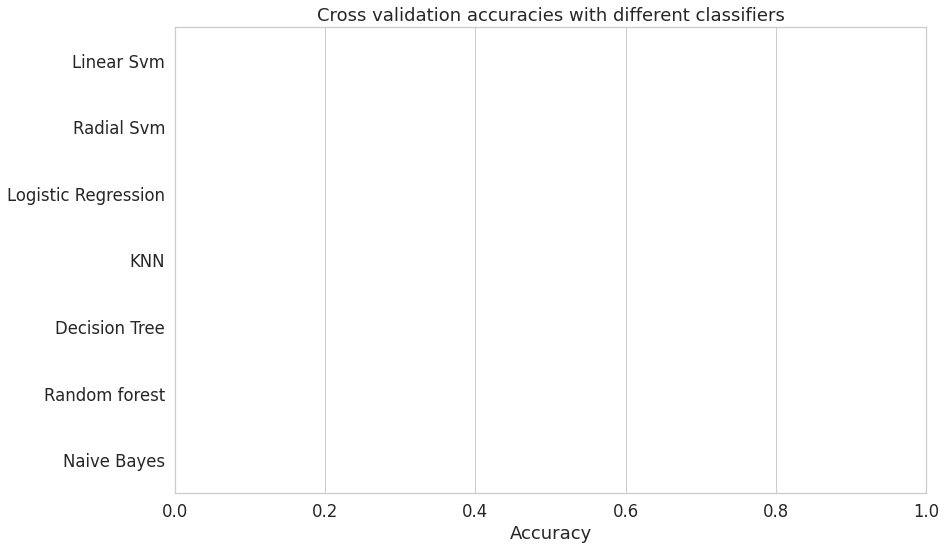

In [ ]:
ax = sns.boxplot(data=boxT, orient="h", palette="Set2", width=.6)
ax.set_yticklabels(classifiers)
ax.set_title('Cross validation accuracies with different classifiers')
ax.set_xlabel('Accuracy')
plt.show()

# Ensembling

In [ ]:
linear_svm=svm.SVC(kernel='linear',C=0.1,gamma=10, probability=True)
radial_svm=svm.SVC(kernel='rbf',C=0.1,gamma=10, probability=True)
lr=LogisticRegression(C=0.1)
dt=DecisionTreeClassifier()

In [ ]:
from sklearn.ensemble import VotingClassifier #for Voting Classifier

# **Ensembling**
## **Ensamble with 3 classifiers combined: Linear SVM, radial SVM, Log Reg**

In [ ]:
linear_svm=svm.SVC(kernel='linear',C=0.1,gamma=10, probability=True)
radial_svm=svm.SVC(kernel='rbf',C=0.1,gamma=10, probability=True)
lr=LogisticRegression(C=0.1)

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
ensembleModel=VotingClassifier(estimators=[('Linear_svm',linear_svm), ('Radial_svm', radial_svm), ('Logistic Regression', lr)], 
                                            voting='soft', weights=[1,2,3])

ensembleModel.fit(train_X,train_Y)
predictEnsemble = ensembleModel.predict(test_X)

In [ ]:
print('Accuracy of ensembled model with all the 4 classifiers is:', np.round(ensembleModel.score(test_X,test_Y), 4))

Accuracy of ensembled model with all the 4 classifiers is: 0.79


# **ROC curve with AUC**

In [ ]:
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, 
                             classification_report, f1_score, average_precision_score, precision_recall_fscore_support)

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_Y, predictEnsemble)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7877395642534665

Text(0.5, 0, 'num_sessions')

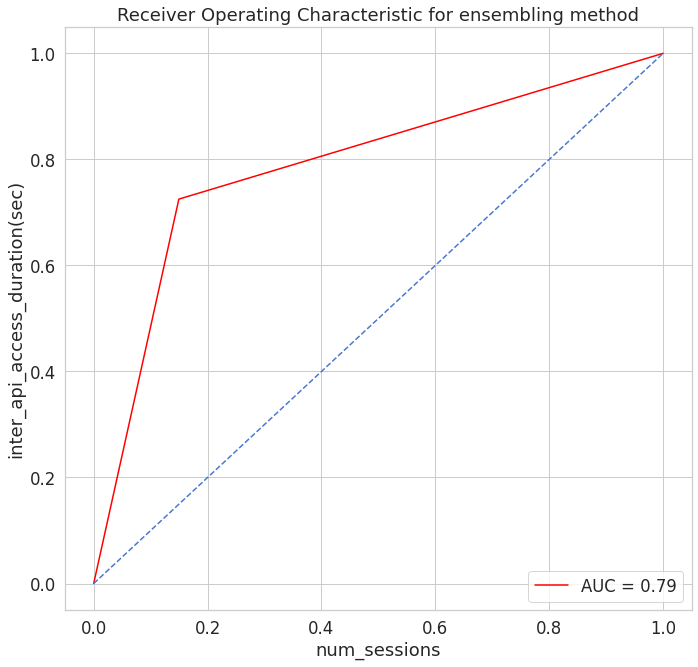

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic for ensembling method')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('inter_api_access_duration(sec)')
plt.xlabel('num_sessions')

# **For all methods**

In [ ]:
# Logistic regression
modelLR = LogisticRegression()
modelLR.fit(train_X,train_Y)
y_pred_prob_lr = modelLR.predict_proba(test_X)[:,1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(test_Y, y_pred_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
precision_lr, recall_lr, th_lr = precision_recall_curve(test_Y, y_pred_prob_lr)

# SVM with rbf
modelSVMrbf=svm.SVC(kernel='rbf', probability=True)
modelSVMrbf.fit(train_X,train_Y)
y_pred_prob_SVMrbf = modelSVMrbf.predict_proba(test_X)[:,1]
fpr_SVMrbf, tpr_SVMrbf, thresholds_SVMrbf = roc_curve(test_Y, y_pred_prob_SVMrbf)
roc_auc_SVMrbf = auc(fpr_SVMrbf, tpr_SVMrbf)
precision_SVMrbf, recall_SVMrbf, th_SVMrbf = precision_recall_curve(test_Y, y_pred_prob_SVMrbf)

# SVM with linear
modelSVMlinear=svm.SVC(kernel='linear', probability=True)
modelSVMlinear.fit(train_X,train_Y)
y_pred_prob_SVMlinear = modelSVMlinear.predict_proba(test_X)[:,1]
fpr_SVMlinear, tpr_SVMlinear, thresholds_SVMlinear = roc_curve(test_Y, y_pred_prob_SVMlinear)
roc_auc_SVMlinear = auc(fpr_SVMlinear, tpr_SVMlinear)
precision_SVMlinear, recall_SVMlinear, th_SVMlinear = precision_recall_curve(test_Y, y_pred_prob_SVMlinear)

# KNN
modelKNN = KNeighborsClassifier(n_neighbors=3)
modelKNN.fit(train_X,train_Y)
y_pred_prob_KNN = modelKNN.predict_proba(test_X)[:,1]
fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(test_Y, y_pred_prob_KNN)
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)
precision_KNN, recall_KNN, th_KNN = precision_recall_curve(test_Y, y_pred_prob_KNN)


# Decision Tree
modelTree=DecisionTreeClassifier()
modelTree.fit(train_X,train_Y)
y_pred_prob_Tree = modelTree.predict_proba(test_X)[:,1]
fpr_Tree, tpr_Tree, thresholds_Tree = roc_curve(test_Y, y_pred_prob_Tree)
roc_auc_Tree = auc(fpr_Tree, tpr_Tree)
precision_Tree, recall_Tree, th_Tree = precision_recall_curve(test_Y, y_pred_prob_Tree)

# Random forest
modelRF= RandomForestClassifier(n_estimators=100,random_state=0)
modelRF.fit(train_X,train_Y)
y_pred_prob_rf = modelRF.predict_proba(test_X)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_Y, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
precision_rf, recall_rf, th_rf = precision_recall_curve(test_Y, y_pred_prob_rf)


# Naive Bayes
modelNB= GaussianNB()
modelNB.fit(train_X,train_Y)
y_pred_prob_nb = modelNB.predict_proba(test_X)[:,1]
fpr_nb, tpr_nb, thresholds_nb = roc_curve(test_Y, y_pred_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
precision_nb, recall_nb, th_nb = precision_recall_curve(test_Y, y_pred_prob_nb)

# Ensemble 
y_pred_prob_en = ensembleModel.predict_proba(test_X)[:,1]
fpr_en, tpr_en, thresholds_en = roc_curve(test_Y, y_pred_prob_en)
roc_auc_en = auc(fpr_en, tpr_en)
precision_en, recall_en, th_en = precision_recall_curve(test_Y, y_pred_prob_en)

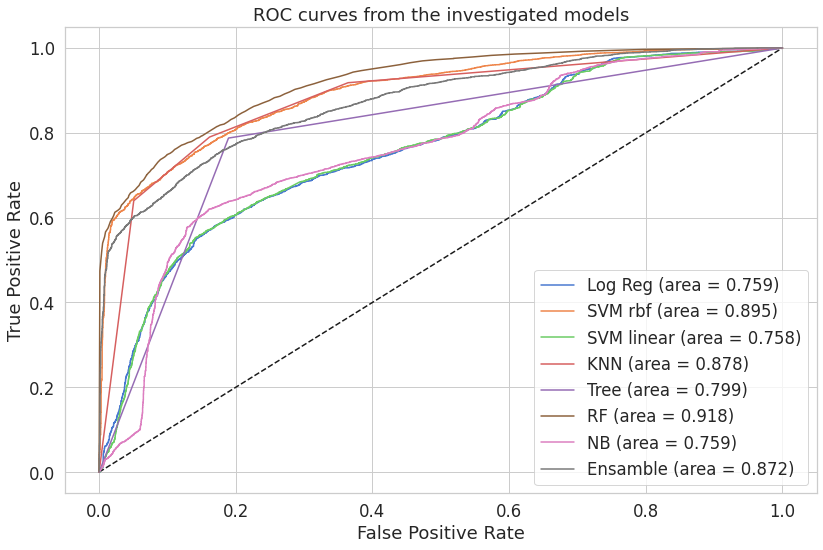

In [ ]:
# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='Log Reg (area = %0.3f)' % roc_auc_lr)
plt.plot(fpr_SVMrbf, tpr_SVMrbf, label='SVM rbf (area = %0.3f)' % roc_auc_SVMrbf)
plt.plot(fpr_SVMlinear, tpr_SVMlinear, label='SVM linear (area = %0.3f)' % roc_auc_SVMlinear)
plt.plot(fpr_KNN, tpr_KNN, label='KNN (area = %0.3f)' % roc_auc_KNN)
plt.plot(fpr_Tree, tpr_Tree, label='Tree (area = %0.3f)' % roc_auc_Tree)
plt.plot(fpr_rf, tpr_rf, label='RF (area = %0.3f)' % roc_auc_rf)
plt.plot(fpr_nb, tpr_nb, label='NB (area = %0.3f)' % roc_auc_nb)
plt.plot(fpr_en, tpr_en, label='Ensamble (area = %0.3f)' % roc_auc_en)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves from the investigated models')
plt.legend(loc='best')
plt.show()

# Precision-recall curve comparing the models

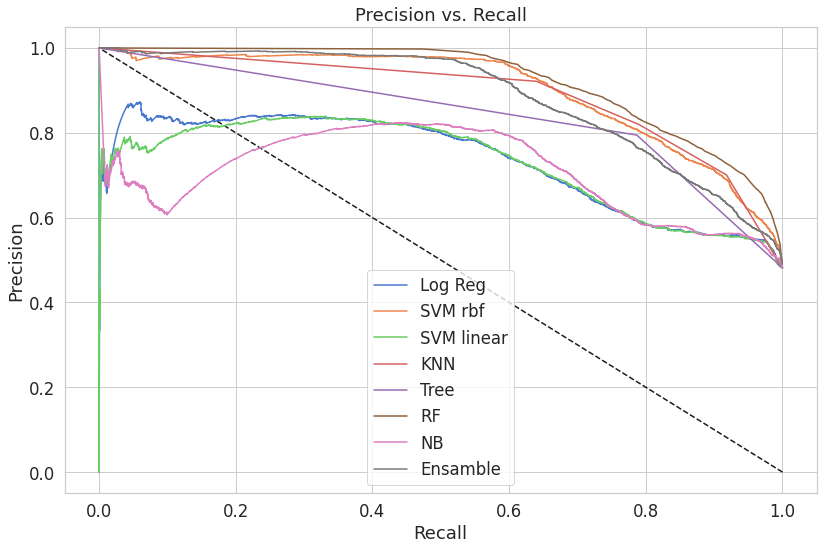

In [ ]:
plt.plot([1, 0], [0, 1], 'k--')
plt.plot(recall_lr, precision_lr, label='Log Reg')
plt.plot(recall_SVMrbf, precision_SVMrbf, label='SVM rbf')
plt.plot(recall_SVMlinear, precision_SVMlinear, label='SVM linear')
plt.plot(recall_KNN, precision_KNN, label='KNN')
plt.plot(recall_Tree, precision_Tree, label='Tree')
plt.plot(recall_rf, precision_rf, label='RF')
plt.plot(recall_nb, precision_nb, label='NB')
plt.plot(recall_en, precision_en, label='Ensamble')
plt.title('Precision vs. Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

# Confusion matrix with ensemble model

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

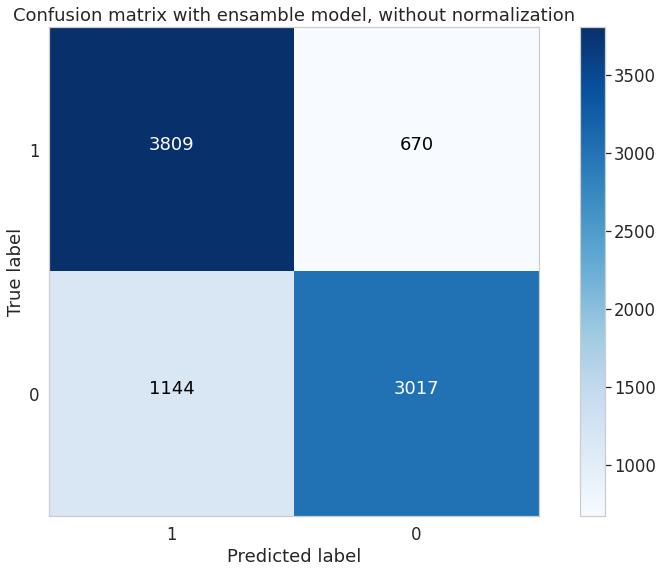

In [ ]:
class_names = test_Y.unique()
cmEnsamble = confusion_matrix(test_Y, predictEnsemble)
plt.grid(False)
plot_confusion_matrix(cmEnsamble, classes=class_names, title='Confusion matrix with ensamble model, without normalization')


# Classification Report

In [ ]:
print(metrics.classification_report(test_Y, predictEnsemble))

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      4479
           1       0.82      0.73      0.77      4161

    accuracy                           0.79      8640
   macro avg       0.79      0.79      0.79      8640
weighted avg       0.79      0.79      0.79      8640




# Cost-sensitive learning

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau

# fix random seed for reproducibility
np.random.seed(42)

In [ ]:
train_Y = to_categorical(train_Y, num_classes = 2)
test_Y = to_categorical(test_Y, num_classes = 2)

In [ ]:
# Confirm the train-test split ratio
print(np.shape(train_X))
print(np.shape(train_Y))
print(np.shape(test_X))
print(np.shape(test_Y))

(25917, 6)
(25917, 2)
(8640, 6)
(8640, 2)


# Create the model using Keras

In [ ]:
# A regularizer that applies a L2 regularization penalty.
# The L2 regularization penalty is computed as: loss = l2 * reduce_sum(square(x))
# Try the model with and without the regularizer

model = Sequential()
model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [ ]:
df=df.style.hide_index()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 72        
                                                                 
 dense_7 (Dense)             (None, 12)                108       
                                                                 
 dense_8 (Dense)             (None, 12)                156       
                                                                 
 dense_9 (Dense)             (None, 8)                 104       
                                                                 
 dense_10 (Dense)            (None, 4)                 36        
                                                                 
 dense_11 (Dense)            (None, 2)                 10        
                                                                 
Total params: 486
Trainable params: 486
Non-trainable 

# Compile the model

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#  Fit model

In [ ]:
epoch = 100
batch_size = 500

history = model.fit(train_X, train_Y, batch_size = batch_size, epochs = epoch, 
          validation_data = (test_X, test_Y), verbose = 2)

Epoch 1/100


ValueError: ignored

In [ ]:
score, acc = model.evaluate(test_X, test_Y)
print('Test score:', score)
print('Test accuracy:', acc)

In [ ]:
# Plot the loss and accuracy curves for training and validation vs. epochs

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Testing loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Testing accuracy")
legend = ax[1].legend(loc='best', shadow=True)

plt.show()

#**Association Rules**

In [ ]:
from google.colab import files
files.upload()

In [ ]:
import pandas as pd

df = pd.read_csv('apis.csv', header = None)

#Check number of rows and columns in the dataset
print("The dataset has %d rows and %d columns." % df.shape)

In [ ]:
!pip install squarify

In [ ]:
!pip install wordcloud

In [ ]:
# for basic operations
import numpy as np
import pandas as pd

# for visualizations
import matplotlib.pyplot as plt
import squarify
import seaborn as sns
plt.style.use('fivethirtyeight')

# for defining path
import os

# for market basket analysis
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#**Dataset Visualization**


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from os import path


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 2  ).generate(str(df[11]))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Items',fontsize = 20)
plt.show()

In [ ]:
# looking at the frequency of most popular items 

plt.rcParams['figure.figsize'] = (18, 7)
color = plt.cm.copper(np.linspace(0, 1, 121))
df[11].value_counts().head(4000).plot.bar(color = color)
plt.title('frequency of most popular Service', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [ ]:
y = df[11].value_counts().head().to_frame()
y.index

In [ ]:
# plotting a tree map

plt.rcParams['figure.figsize'] = (15, 15)
color = plt.cm.cool(np.linspace(0, 1, 40))
squarify.plot(sizes = y.values, label = y.index, alpha=.8, color = color)
plt.title('Tree Map for Popular Service')
plt.axis('off')
plt.show()

In [ ]:
df['service'] = 'Service'
service = df.truncate(before = -1, after = 15000)

import networkx as nx

service = nx.from_pandas_edgelist(service, source = 'service', target = 11, edge_attr = True)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (20, 20)
pos = nx.spring_layout(service)
color = plt.cm.Wistia(np.linspace(0, 15, 1))
nx.draw_networkx_nodes(service, pos, node_size = 15000, node_color = color)
nx.draw_networkx_edges(service, pos, width = 3, alpha = 0.6, edge_color = 'black')
nx.draw_networkx_labels(service, pos, font_size = 20, font_family = 'sans-serif')
plt.axis('off')
plt.grid()
plt.title('Top 15 First Choices', fontsize = 40)
plt.show()

Now we can check the second choices of the customers for all data. 

In [ ]:
df['secondchoice'] = 'Second Choice'
secondchoice = df.truncate(before = -1, after = 100)
secondchoice = nx.from_pandas_edgelist(secondchoice, source = 'service', target = 10, edge_attr = True)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (20, 20)
pos = nx.spring_layout(secondchoice)
color = plt.cm.Blues(np.linspace(0, 15, 1))
nx.draw_networkx_nodes(secondchoice, pos, node_size = 15000, node_color = color)
nx.draw_networkx_edges(secondchoice, pos, width = 3, alpha = 0.6, edge_color = 'brown')
nx.draw_networkx_labels(secondchoice, pos, font_size = 20, font_family = 'sans-serif')
plt.axis('off')
plt.grid()
plt.title('Top 100 Second Choices', fontsize = 40)
plt.show()

Now we can check the third choices of the customers for all data. 

In [ ]:
df['thirdchoice'] = 'Third Choice'
thirdchoice = df.truncate(before = -1, after = 10)
thirdchoice = nx.from_pandas_edgelist(thirdchoice, source = 'service', target = 2, edge_attr = True)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (20, 20)
pos = nx.spring_layout(thirdchoice)
color = plt.cm.Reds(np.linspace(0, 15, 1))
nx.draw_networkx_nodes(thirdchoice, pos, node_size = 15000, node_color = color)
nx.draw_networkx_edges(thirdchoice, pos, width = 3, alpha = 0.6, edge_color = 'pink')
nx.draw_networkx_labels(thirdchoice, pos, font_size = 20, font_family = 'sans-serif')
plt.axis('off')
plt.grid()
plt.title('Top 10 Third Choices', fontsize = 40)
plt.show()


# **Data Preprocessing**

There are two principal methods of representing this type of market basket data:
using either the transactional data format or the tabular data format. The transactional data format requires only two fields, an ID field and a content field,
with each record representing a single item only.

For example, the data in Table 1 could be represented using transactional data
format as shown in Table 2. In the tabular data format, each record represents
a separate transaction, with as many 0/1 flag fields as there are items. The data
from Table 2 could be represented using the tabular data format, as shown in
Figure 1.

In [ ]:
# making each customers shopping items an identical list
trans = []
for i in range(0, 50):
    trans.append([str(df.values[i,j]) for j in range(0, 11)])

# conveting it into an numpy array
trans = np.array(trans)

# checking the shape of the array
print(trans.shape)

In [ ]:
trans[:,0:6]

In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
df = te.fit_transform(trans)
df = pd.DataFrame(df, columns = te.columns_)

# getting the shape of the data
df.shape

In [ ]:
df.head(10)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# getting correlations for 121 items would be messy 
# so let's reduce the items from 121 to 50

df = df.loc[:, [ 'inter_api_access_duration(sec)', 'api_access_uniqueness',
       'sequence_length(count)', 'vsession_duration(min)', 'ip_type',
       'behavior', 'behavior_type', 'num_sessions', 'num_users',
       'num_unique_apis']]

# checking the shape
df.shape

In [ ]:
df.columns

In [ ]:
df.head()

# **Apriori Algorithm**

## **Finding Frequent itemsets**

In [ ]:
from mlxtend.frequent_patterns import apriori

#Now, let us return the items and itemsets with at least 5% support:
apriori(df, min_support = 0.03, use_colnames = True)


In [ ]:
frequent_itemsets = apriori(df, min_support = 0.05, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

In [ ]:
# getting th item sets with length = 2 and support more han 10%

frequent_itemsets[ (frequent_itemsets['length'] == 2) &
                   (frequent_itemsets['support'] >= 0.05) ]


## Finding Association Rules

In [ ]:
rules_mlxtend = association_rules(frequent_itemsets, metric="support", min_threshold=0.02)
rules_mlxtend.sort_values(by=["support"],ascending=False)

In [ ]:
rules_mlxtend[ (rules_mlxtend['lift'] >= 1) & (rules_mlxtend['confidence'] >= 0.3) ].head()